![image.png](image.png)

In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn

In [2]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))] # Input

        layers.append(('input_activation', act())) # Activation

        for i in range(depth): 
            layers.append(('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))) # Hidden Layer
            layers.append(('activation_%d' % i, act())) # Activation for Hidden Layer

        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
        
        
        # Create spatial and temporal grids for the problem domain
        self.h = 0.1 # This defines the step size (or spacing) for the spatial dimension (x).
        self.k = 0.1 # This defines the step size (or spacing) for the temporal dimension (t).
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)

        #  Constructs a 2D grid of all possible spatial (x) and temporal (t) combinations
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
        
        # Boundary and Initial Condition Datas
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T # Boundary condition at 𝑥=−1 (i.e., x[0]), with all values of t.
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T # Boundary condition at 𝑥=1 (i.e., x[-1]), with all values of t.
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T # Initial condition at t=0 (i.e., t[0]), with all values of x.
        
        self.X_train = torch.cat([bc1, bc2, ic])
        # Boundary and Initial Condition Values
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])

        # Concatenating Target Values
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1) # This adds an extra dimension at position 1 (the second dimension), which is required for the neural network outpu
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True

        # Loss and Optimizers
        self.criterion = torch.nn.MSELoss() # Mean squared error (MSE) loss
        self.iter = 1
        
# Two optimizers:
# Adam: Used for initial training.
# LBFGS: A second-order optimizer for fine-tuning.
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",   # better numerical stability
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())


    # Combining two terms: data loss (to fit boundary and initial conditions) and PDE loss (to enforce the governing Burgers' equation)
    def loss_func(self):
        # Resetting Gradients: avoid accumulation during backpropagation
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # Data Loss Calculation
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)

        # Physics Loss Calculation (Enforcing the Burgers' Equation)
        u = self.model(self.X) # Predict 𝑢(𝑥,𝑡) Across the Entire Domain
        
       # First Derivatives
        du_dX = torch.autograd.grad(
            inputs=self.X, 
            outputs=u, 
            grad_outputs=torch.ones_like(u), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]

        # Second Derivative
        du_dxx = torch.autograd.grad(
            inputs=self.X, 
            outputs=du_dX, 
            grad_outputs=torch.ones_like(du_dX), 
            retain_graph=True, 
            create_graph=True
        )[0][:, 0]

        # Enforce Burgers' Equation
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 / math.pi * du_dxx)

        # Combine Losses
        loss = loss_pde + loss_data
        loss.backward()

        # Iterative Updates
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
        
    def eval_(self):
        self.model.eval()

# Training

In [4]:
net = Net()
net.train()

C:\Users\lenovo\Desktop\PINN\myenv\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
C:\Users\lenovo\Desktop\PINN\myenv\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100 0.14943470060825348
200 0.08616840839385986
300 0.06934791058301926
400 0.051592499017715454
500 0.024407820776104927
600 0.021752581000328064
700 0.013939851894974709
800 0.010241433046758175
900 0.00883820652961731
1000 0.00959760695695877
1100 0.003690598998218775
1200 0.0013237383682280779
1300 0.0006680632359348238
1400 0.0004992844769731164
1500 0.0003406035539228469
1600 0.0002398333017481491
1700 0.00019789946964010596
1800 0.00016230190522037446
1900 0.00014275839203037322
2000 0.00012010739010293037
2100 0.00010717808618210256
2200 9.698877693153918e-05
2300 8.499564864905551e-05
2400 7.652605563635007e-05
2500 6.454217509599403e-05
2600 5.812633753521368e-05
2700 5.2639341447502375e-05
2800 4.8071415221784264e-05
2900 4.525555414147675e-05
3000 4.211385748931207e-05
3100 4.0526341763325036e-05
3200 3.837211988866329e-05
3300 3.693326289067045e-05
3400 3.5470300645101815e-05
3500 3.3763371902750805e-05
3600 3.3486470783827826e-05
3700 3.0591687391279265e-05
3800 2.9014114

# Evaluation

In [5]:
# net.eval_()
net.model.eval()
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [6]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

In [8]:
sns.set_style("white")

plt.figure(figsize=(5, 3), dpi=3000)

<Figure size 15000x9000 with 0 Axes>

<Figure size 15000x9000 with 0 Axes>

### **Significance of `y_pred` in Terms of the Burgers' Equation**

The array `y_pred` represents the **model's predicted values** of the solution \( u(x, t) \) to the Burgers' equation at the training points defined in the spatial-temporal grid \( \mathbf{X}_{\text{train}} \). Here's what it signifies:

---

### **1. Predicted Solution Values**
- Each entry in the array corresponds to a predicted \( u(x, t) \), where:
  - **Rows**: Represent different time steps \( t \).
  - **Columns**: Represent different spatial locations \( x \).
- For example:
  - `y_pred[0][0]`: The predicted value of \( u(x, t) \) at the first spatial location \( x \) and the first time step \( t \).
  - `y_pred[-1][-1]`: The predicted value of \( u(x, t) \) at the last spatial location \( x \) and the last time step \( t \).

---

### **2. Interpretation in Terms of the Burgers' Equation**
The Burgers' equation is:
![Alt Text](image1.png)


---

### **3. Observations**
- **Values close to \( 0 \)**: Indicate that the solution at that point approaches the steady-state or initial conditions where \( u(x, t) \) might be near zero.
- **Positive values**: Indicate upward deviation or propagation of waves.
- **Negative values**: Indicate downward deviation or dissipation of waves.

---


### **In Summary**
The `y_pred` array represents the neural network's approximation of the solution u(x, t) across the spatial-temporal domain. It serves as a critical component in:
- Evaluating how well the network satisfies the Burgers' equation through the **PDE loss**.
- Fitting the boundary and initial conditions through the **data loss**.

In [9]:
y_pred

array([[ 0.00215105,  0.00182072,  0.00154612, ..., -0.00142535,
        -0.00145742, -0.0014924 ],
       [ 0.0332996 ,  0.03201769,  0.03084669, ...,  0.00625411,
         0.00616673,  0.00607804],
       [ 0.06439368,  0.0621672 ,  0.06010381, ...,  0.01393137,
         0.0137888 ,  0.01364551],
       ...,
       [-0.09248366, -0.08996549, -0.08762803, ..., -0.02481212,
        -0.02462514, -0.02444287],
       [-0.06114741, -0.05956497, -0.05811175, ..., -0.01683243,
        -0.0167044 , -0.01657983],
       [-0.02971431, -0.0290732 , -0.02850779, ..., -0.00883403,
        -0.00876471, -0.00869825]], dtype=float32)

<Axes: >

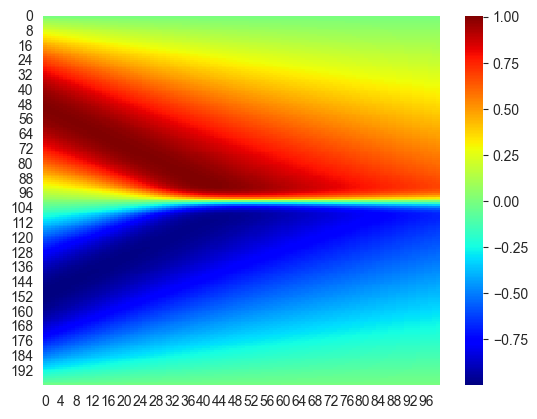

In [10]:
sns.heatmap(y_pred, cmap='jet')